# Imports

In [48]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True
np.random.seed(42)

def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
        "Grab a batch of data and call reduction function `func` per channel"
        funcs = ifnone(funcs, [torch.mean,torch.std])
        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
        return [func(channel_view(x), 1) for func in funcs]
    
    
vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 96
bs = 128
dropout = 0.5
tta_beta = 0.4
tta_scale = 1.35

# n 

In [58]:
n = np.load('n.npy')
n

array(82)

In [59]:
m = n+1
#m=78
np.save('n', m)
m

83

# Data 

In [6]:
#get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
#                      max_lighting=0.05, max_warp=0.)

tfms = ([crop(size=sz),
        RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
      #RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
     [crop(size=sz)])

data = (ImageList.from_csv(path=PATH, csv_name=CSV_NAME, folder=TRAIN_NAME, suffix='.tif')
.random_split_by_pct(0.01)
#.no_split()
.label_from_df()
.add_test_folder(test_folder=TEST_NAME, label=None)
.transform(tfms)
.databunch(bs=bs, num_workers=nw)
#.normalize(imagenet_stats))
.normalize())

# Metrics 

In [7]:
def roc_curve_custom(y_pred:torch.Tensor, y_true:torch.Tensor):
    probs = y_pred[:,-1]
    fpr, tpr, thresholds = roc_curve(y_true, probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def auc_score_1(y_pred:torch.Tensor, y_true:torch.Tensor):
    fpr, tpr, thresholds, roc_auc = roc_curve_custom(y_pred, y_true)
    return torch.as_tensor(roc_auc)

def auc_score_2(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

# Learner

## Create

In [8]:
arch = torchvision.models.vgg16

In [9]:
learner = create_cnn(data=data, 
                     arch=arch, 
                     metrics=[accuracy, auc_score_1, auc_score_2], 
                     ps=dropout, 
                     pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/Deep_Learner/.torch/models/vgg16-397923af.pth
553433881it [00:47, 11677533.67it/s]


## Name

In [51]:
nameBase = f'{n}-{arch.__name__}-cropped_{sz}_ps{dropout}-99%_dataset'
nameBase

'81-vgg16-cropped_96_ps0.5-99%_dataset'

## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


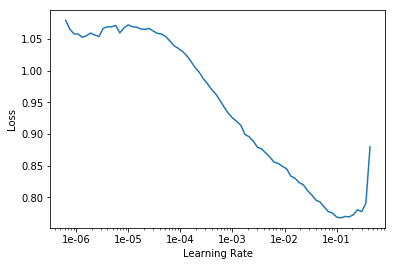

In [11]:
learner.lr_find()
learner.recorder.plot()

In [12]:
lr = 3e-2

In [13]:
learner.fit_one_cycle(cyc_len=1, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,auc_score_1,auc_score_2,time
1,0.355195,0.316880,0.861364,0.938272,0.938272,16:15


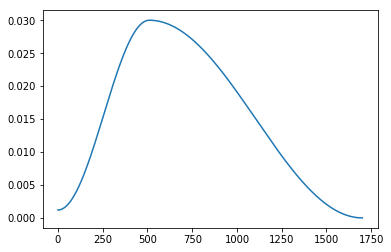

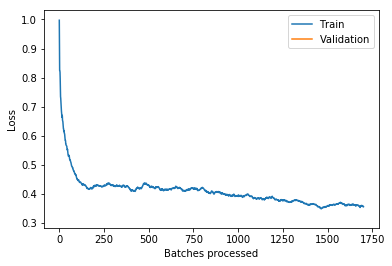

In [14]:
learner.recorder.plot_lr()
learner.recorder.plot_losses()

In [15]:
nameHead = f'{nameBase}-head'
learner.save(nameHead)

In [16]:
#learner.load(nameHead)

In [17]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


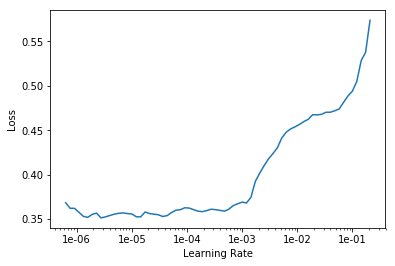

In [18]:
learner.lr_find()
learner.recorder.plot()

In [19]:
lr2 = 1e-4
lr3 = 1e-3

In [20]:
learner.fit_one_cycle(cyc_len=20, max_lr=slice(lr2, lr3))

epoch,train_loss,valid_loss,accuracy,auc_score_1,auc_score_2,time
1,0.200271,0.176163,0.927727,0.980873,0.980873,05:04
2,0.166187,0.144467,0.941364,0.986732,0.986732,05:06
3,0.139400,0.120372,0.952727,0.991290,0.991290,05:07
4,0.145481,0.124334,0.950909,0.993305,0.993305,05:05
5,0.118180,0.146768,0.951818,0.987679,0.987679,05:06
6,0.108438,0.096097,0.965909,0.994038,0.994038,05:05
7,0.096954,0.107208,0.958636,0.993777,0.993777,05:05
8,0.096417,0.115584,0.960000,0.993355,0.993355,05:04
9,0.088556,0.073901,0.973182,0.996056,0.996056,05:05
10,0.084032,0.087466,0.969091,0.994439,0.994439,05:05


In [21]:
nameComplete = f'{nameBase}-complete'
learner.save(nameComplete)

# Interpreter

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(16)

# Validation Set

## Prediction

In [28]:
preds,y=learner.TTA(ds_type=DatasetType.Valid, scale=1)

## AUC Score

In [29]:
pred_score_tta_1=auc_score_1(preds,y)
pred_score_tta_1

tensor(0.9981)

In [30]:
pred_score_tta_2=auc_score_2(preds,y)
pred_score_tta_2

tensor(0.9981)

## ROC curve and AUC on validation set

In [31]:
fpr, tpr, thresholds, roc_auc = roc_curve_custom(preds, y)

In [32]:
roc_auc

0.9980848414551811

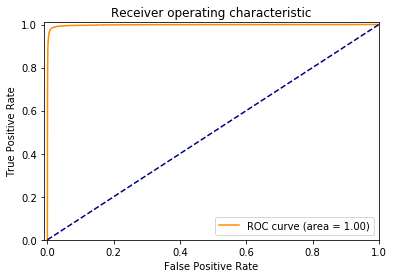

In [33]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Finding threshold on validation set

In [34]:
import scipy.optimize as opt
from sklearn.model_selection import train_test_split

In [35]:
pred = preds[:, 1]

In [36]:
pred_tensor = pred
y_tensor = y

pred = np.asarray(pred)
y = np.asarray(y)

In [37]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(1)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [38]:
import sklearn
th = fit_val(pred, y)
print('Thresholds: ',th)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ', sklearn.metrics.f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))

Thresholds:  [0.498545]
F1 macro:  0.9849769628141016
F1 macro (th = 0.0):  0.28832500444746334
F1 micro:  0.9855243722304283


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score +=  sklearn.metrics.f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))


print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Thresholds:  [0.481899]
F1 macro avr: 0.9848190787747916
F1 macro:  0.9850265550264219
F1 micro:  0.9855698216111806
Fractions:  0.4043858652425861
Fractions (true):  0.40513578002499717


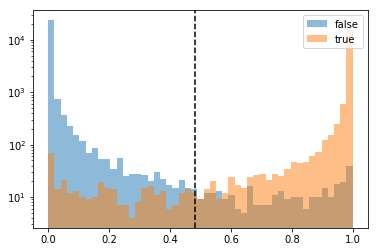

In [40]:
f1 =  sklearn.metrics.f1_score(y, pred>th, average=None)
bins = np.linspace(pred[:].min(), pred[:].max(), 50)
plt.hist(pred[y[:] == 0][:], bins, alpha=0.5, log=True, label='false')
plt.hist(pred[y[:] == 1][:], bins, alpha=0.5, log=True, label='true')
plt.legend(loc='upper right')
plt.axvline(x=th[0], color='k', linestyle='--')
plt.show()

# Test Set

## Single Model

In [52]:
#learner.load('vgg16-cropped_96_ps0.5-99%_dataset-complete')

In [53]:
nameBase

'81-vgg16-cropped_96_ps0.5-99%_dataset'

In [54]:
preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=tta_scale, beta=tta_beta)
preds_test = preds_test_tta

#preds_test, _ = learner.get_preds(ds_type=DatasetType.Test)

In [55]:
name = f'{nameBase}-tta_scale{tta_scale}.csv'

## Ensembling

In [73]:
#arch_list = [xception, inceptionv4, densenet169, vgg13, vgg16, vgg19, resnet18]
arch_list = [densenet169, vgg16]

In [74]:
dict_arch_savedModel = {densenet169:'densenet169-cropped_96-complete',
                        vgg13:'vgg13-cropped_96_ps0.5-99%_dataset-complete',
                        vgg16:'vgg16-cropped_96_ps0.5-99%_dataset-complete',
                        vgg19:'68-vgg19-cropped_96_ps0.5-99%_dataset-complete',
                        resnet18:'67-resnet18-cropped_96_ps0.5-99%_dataset-complete',
                        xception:'69-xception-cropped_96_ps0.5-99%_dataset-complete',
                        inceptionv4:'70-inceptionv4-cropped_96_ps0.5-99%_dataset-complete'}

In [75]:
str([a.__name__ for a in arch_list])

"['densenet169', 'vgg16']"

In [76]:
name = f'{n}-{str([a.__name__ for a in arch_list])}_sz{sz}_ensembled.csv'; name

"82-['densenet169', 'vgg16']_sz96_ensembled.csv"

In [ ]:
predsList = []
for arch in arch_list:
    learner = create_cnn(data=data, arch=arch)
    learner.load(dict_arch_savedModel[arch])
    preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=1)
    predsList.append(preds_test_tta)

In [ ]:
preds_ensembled = predsList[0]
for n, _ in enumerate(predsList):
    if n == 0:
        continue
    else:
        preds_ensembled = preds_ensembled + predsList[n]
preds_ensembled = preds_ensembled/len(predsList)

In [ ]:
preds_test = preds_ensembled

# Submission

In [ ]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fnames_cleaned=clean_fname(data.test_ds.items).astype(str)

In [ ]:
probs = np.array(preds_test[:,-1])

#pred_labels = np.where(probs > th, 1, 0)
df = pd.DataFrame({'id':[fname for fname in fnames_cleaned], 'label':probs})
df.to_csv(SUBMISSIONS/f'{name}.csv', header=True, index=False)

## obsolete

In [62]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fnames_cleaned=clean_fname(data.test_ds.items).astype(str)

sub=pd.read_csv(SAMPLE).set_index('id')
sub.loc[fnames_cleaned,'label']=(to_np(preds_test_tta[:,1]) > th).astype(np.int)
name = f'{n}-{arch.__name__}_sz{sz}_bs{bs}_th{th}.csv'
sub.to_csv(SUBMISSIONS/name)